<a href="https://colab.research.google.com/github/sonjoy2074/potato_diseases_detection/blob/main/potato_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pickle import load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Dataset/PlantVillage/PlantVillage/Potato',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2162 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch,labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0]


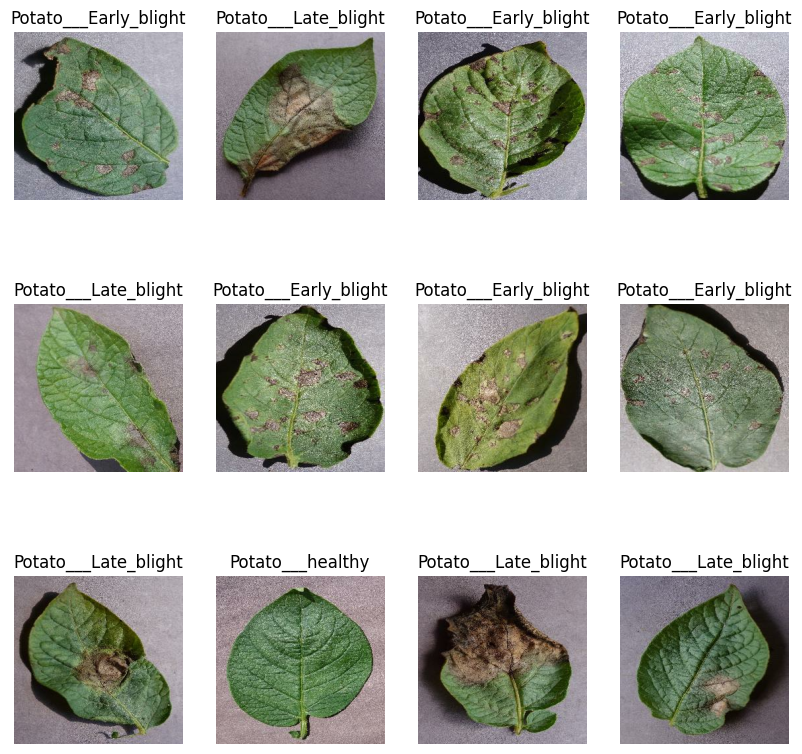

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[labels_batch[i]])
    plt.axis('off')
    #print("Image shape: ", image_batch.numpy().shape)

In [ ]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds=dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)

  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  train_ds=ds.take(train_size)

  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
train_ds=train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])


In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 280s 196ms/step - accuracy: 0.5188 - loss: 2.0790 - val_accuracy: 0.8281 - val_loss: 0.4675
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8060 - loss: 0.4579 - val_accuracy: 0.8750 - val_loss: 0.2767
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8758 - loss: 0.3068 - val_accuracy: 0.9115 - val_loss: 0.2819
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9316 - loss: 0.1710 - val_accuracy: 0.8750 - val_loss: 0.2920
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9305 - loss: 0.1648 - val_accuracy: 0.6615 - val_loss: 1.4478
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8589 - loss: 0.3665 - val_accuracy: 0.8906 - val_loss: 0.2726
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9398 - loss: 0.1465 - val_accuracy: 0.9479 - val_loss: 0.1015
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9435 - loss: 0.1450 - val_accuracy: 0.9479 

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9277 - loss: 0.1953


In [ ]:
test_loss

0.1511283814907074

In [ ]:
test_acc

0.9453125

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

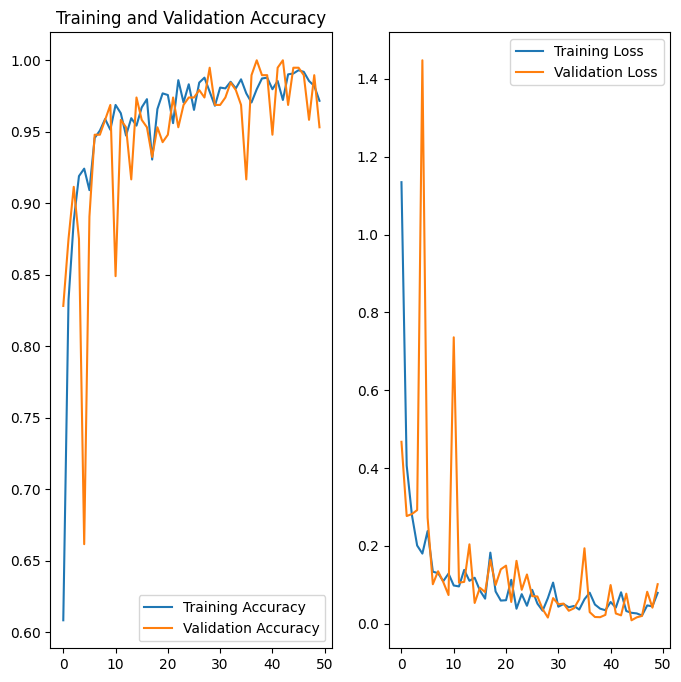

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc,label='Training Accuracy')
plt.plot(range(50),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50),loss,label='Training Loss')
plt.plot(range(50),val_loss,label='Validation Loss')
plt.legend(loc='upper right')

First image to predict
Actual label: Potato___Late_blight
******** Prediction Result *******
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Predicted label: Potato___Late_blight


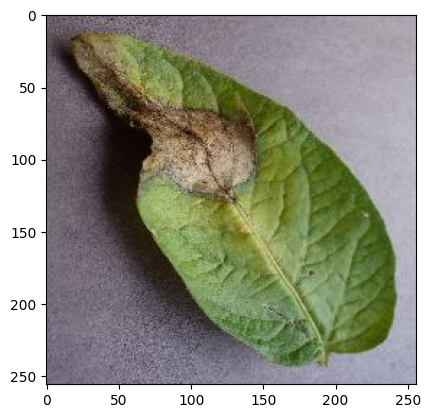

In [ ]:
for image_batch, labels_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print('First image to predict')
  plt.imshow(first_image)
  print('Actual label:',class_names[first_label])

  print("******** Prediction Result *******")
  batch_prediction=model.predict(image_batch)
  print('Predicted label:',class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, image):
    # Ensure image is NumPy
    if not isinstance(image, np.ndarray):
        image = image.numpy()

    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


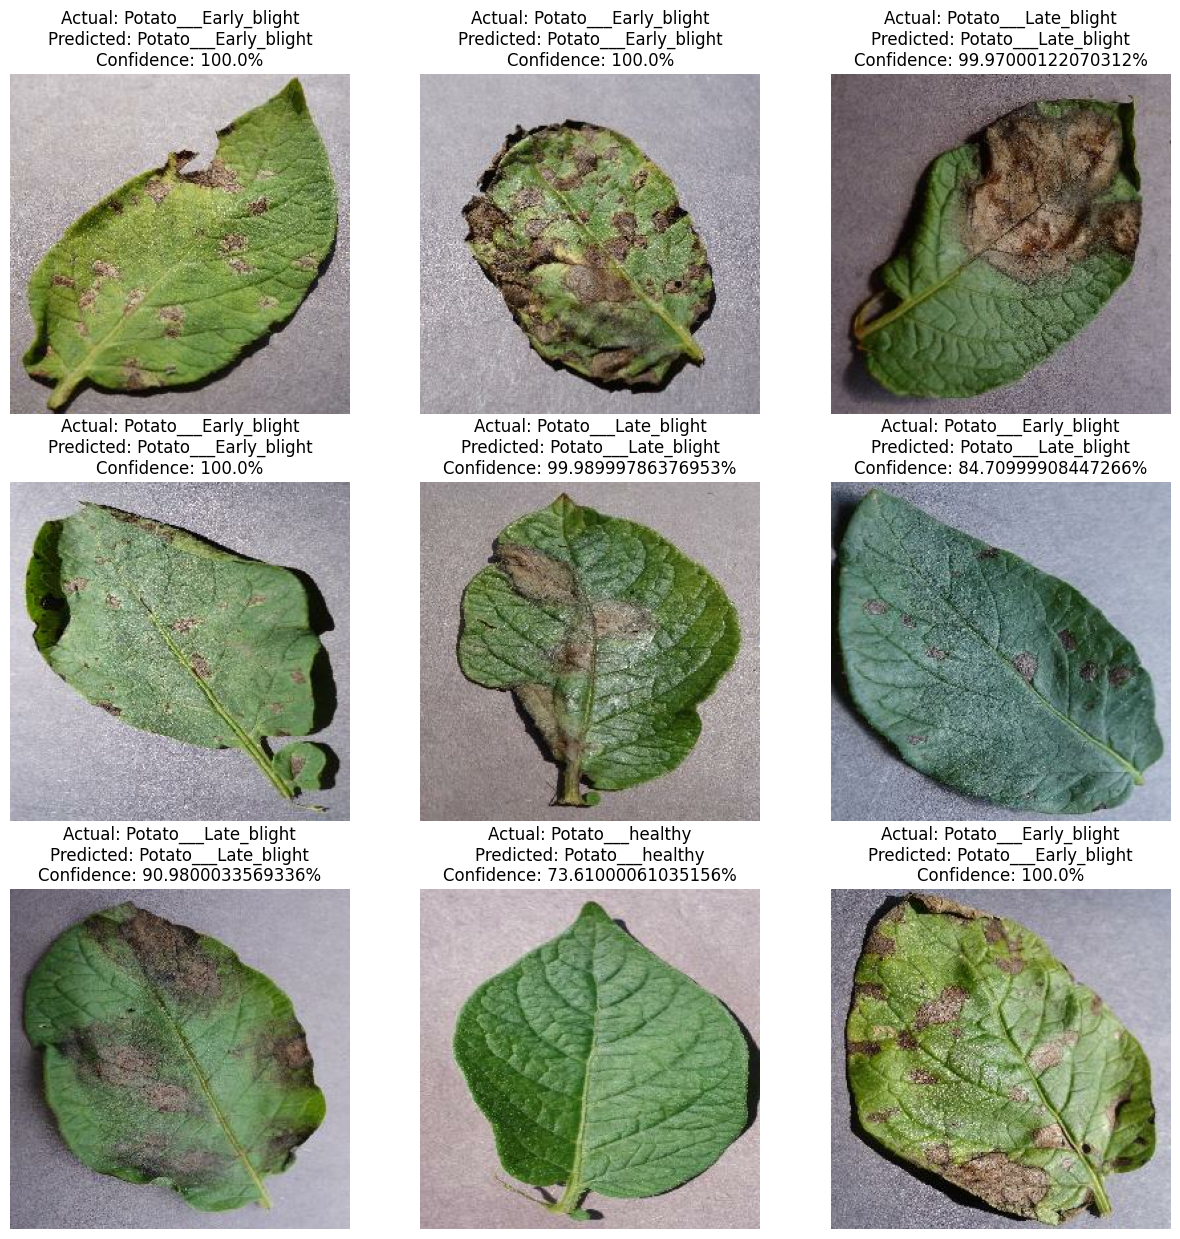

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])  # pass tensor or array
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis('off')

In [ ]:
model_version="potato_diseases_modelv1"
model.save(f'/content/drive/MyDrive/models/{model_version}.keras')

In [ ]:
model_version="potato_diseases_modelv2"
model.save(f'/content/drive/MyDrive/models/{model_version}.h5')

In [ ]:
model_version="potato_diseases_modelv2"
model.export(f'/content/drive/MyDrive/models/{model_version}')

Saved artifact at '/content/drive/MyDrive/models/potato_diseases_modelv2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135245506471184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245506471760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245506469072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245506470992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245500344912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245500345104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245500346064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245500345296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245500346448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135245500346256: TensorSpec(shape=(), dtype=tf.

In [ ]:
print("Hi")

Hi
